In [447]:
% matplotlib inline

In [444]:
import numpy as np
import pandas as pd
import shapefile
import shapely.geometry as sgeom
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cartopy.io.shapereader as shpreader
from collections import defaultdict
from descartes import PolygonPatch
from jenkspy import jenks_breaks
from matplotlib.colors import rgb2hex
from shapely.geometry import Polygon
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

In [445]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [554]:
baselines_df = pd.read_csv("../baselines/baseline_results.csv")

In [601]:
frac = "_pov_rate"
use_pov_rate_label = True

In [602]:
fold_results = []
for i in range(1, 5 + 1):
  fold_data = pd.read_csv("../data/fold_%d/test.csv" % i)
  mu = np.load("../data/fold_%d/mu.npy" % i)
  std = np.load("../data/fold_%d/std.npy" % i)
  true = np.load("./fold_%d%s/y_true.npy" % (i, frac))
  l8 = np.load("./fold_%d%s/y_pred_l8.npy" % (i, frac))
  s1 = np.load("./fold_%d%s/y_pred_s1.npy" % (i, frac))
  
  baselines_df.loc[baselines_df["fold"] == i,"gbm"] = baselines_df.loc[baselines_df["fold"] == i,"gbm"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"knn"] = baselines_df.loc[baselines_df["fold"] == i,"knn"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"ridge"] = baselines_df.loc[baselines_df["fold"] == i,"ridge"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"true"] = baselines_df.loc[baselines_df["fold"] == i,"true"] * std + mu
  
  if use_pov_rate_label:
    mu = 0
    std = 1
  
  fold_results.append(pd.DataFrame({
    "id": fold_data["id"],
    "true": true * std + mu,
    "l8": l8 * std + mu,
    "s1": s1 * std + mu,
    "pred": np.average((l8 * std + mu, s1 * std + mu), axis=0, weights=[0.5, 0.5]),
    "state_idx": fold_data["state_idx"],
    "district_idx": fold_data["district_idx"],
    "taluk_idx": fold_data["taluk_idx"],
    "lat": fold_data["latitude"],
    "lng": fold_data["longitude"],
    "fold": i,
    "secc_hh": fold_data["secc_hh"],
    "secc_pop": fold_data['secc_pop'],
    "secc_pop_scaled": fold_data["secc_pop_scaled"],
    "secc_cons": fold_data["secc_cons"],
    "secc_pov_rate": fold_data["secc_pov_rate"],
    "secc_pov_rate_tend": fold_data["secc_pov_rate_tend"],
    "secc_cons_per_hh": fold_data["secc_cons_per_hh"],
    "secc_cons_per_cap": fold_data["secc_cons_per_cap"], 
    "secc_cons_per_cap_scaled": fold_data["secc_cons_per_cap_scaled"],
    "pc11_hh": fold_data["pc11_hh"],
    "pc11_pop": fold_data["pc11_pop"],
    "pc11_cons": fold_data["pc11_cons"]
  }))

In [603]:
test_df = pd.concat(fold_results)

In [604]:
test_df = test_df.reset_index()

In [605]:
test_df.to_csv("./test_results%s.csv" % frac)

In [606]:
knn = KNeighborsRegressor(n_neighbors=30)

In [607]:
knn.fit(test_df[["lat", "lng"]], test_df["pred"])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=30, p=2,
          weights='uniform')

In [608]:
test_df["smoothed"] = knn.predict(test_df[["lat", "lng"]])

In [609]:
print("Pred: %.3f" % r2_score(test_df["true"], test_df["smoothed"]))
print("GBM: %.3f" % r2_score(test_df["true"], baselines_df["gbm"]))
print("Ridge: %.3f" % r2_score(test_df["true"], baselines_df["ridge"]))

Pred: 0.320
GBM: -5686.526
Ridge: -5686.529


In [580]:
test_df["gbm"] = baselines_df["gbm"]

In [506]:
# print("L8/S1 correlation: %.3f" % test_df["l8"].corr(test_df["s1"]))
# print("KNN/Prediction correlation: %.3f" % test_df["knn"].corr(test_df["pred"]))

In [507]:
print("Percent 3 SD outliers: %.4f" % (1-np.mean((test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3)))

Percent 3 SD outliers: 0.0056


In [610]:
print("Pred: %.3f" % r2_score(test_df["true"], test_df["pred"]))
# print("KNN: %.3f" % r2_score(test_df["true"], test_df["knn"]))
print("Smoothed pred: %.3f" % r2_score(test_df["true"], test_df["smoothed"]))
print("Outliers: %.3f" % r2_score(test_df["true"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3],
                                  test_df["pred"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3]))
print("Outliers smoothed: %.3f" % r2_score(test_df["true"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3],
                                  test_df["smoothed"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3]))
print("Outliers GBM: %.3f" % r2_score(test_df["true"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3],
                                  baselines_df["gbm"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3]))
print("L8: %.3f" % r2_score(test_df["true"], test_df["l8"]))
print("S1: %.3f" % r2_score(test_df["true"], test_df["s1"]))

Pred: 0.291
Smoothed pred: 0.320
Outliers: 0.292
Outliers smoothed: 0.329
Outliers GBM: -6561.786
L8: 0.266
S1: 0.209


In [539]:
pctles = []
r2s_smoothed = []
r2s_gbm = []
for pctle in np.arange(5, 101, 5):
  cutoff = np.percentile(test_df["true"], q=pctle)
  pctles.append(pctle)
  r2s_smoothed.append((test_df["true"][test_df["true"] < cutoff].corr(test_df["smoothed"][test_df["true"] < cutoff])) ** 2)
  r2s_gbm.append((baselines_df["true"][test_df["true"] < cutoff].corr(baselines_df["gbm"][test_df["true"] < cutoff])) ** 2)

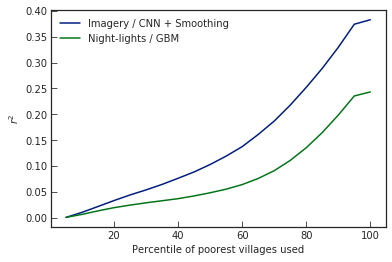

In [540]:
plt.plot(pctles, r2s_smoothed, label="Imagery / CNN + Smoothing")
plt.plot(pctles, r2s_gbm, label="Night-lights / GBM")
plt.xlabel("Percentile of poorest villages used")
plt.ylabel("$r^2$")
plt.legend();

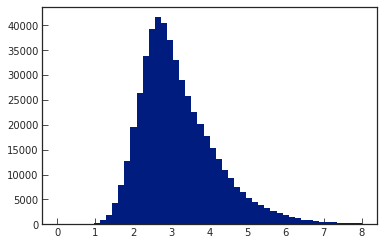

In [563]:
# histogram in $/day
plt.hist((np.exp(test_df["true"]) / 365.25 / 16.013)[np.exp(test_df["true"]) / 365.25 / 16.013 < 8], bins=50);

In [570]:
# https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm
dollars_per_day_true = np.exp(test_df["true"]) / 365.25 / 16.013
dollars_per_day_pred = np.exp(test_df["smoothed"]) / 365.25 / 16.013
# test_df["gbm"] = np.exp(test_df["gbm"]) / 365.25 / 16.013

In [572]:
# sanity check
print(r2_score(dollars_per_day_true, dollars_per_day_pred))
print(r2_score(test_df["true"], test_df["smoothed"]))

0.2655013141411443
0.36647824416998065


In [611]:
preds = {
  "state": test_df.groupby("state_idx")["smoothed"].mean(),
  "district": test_df.groupby("district_idx")["smoothed"].mean(),
  "taluk": test_df.groupby("taluk_idx")["smoothed"].mean(),
}
trues = {
  "state": test_df.groupby("state_idx")["true"].mean(),
  "district": test_df.groupby("district_idx")["true"].mean(),
  "taluk": test_df.groupby("taluk_idx")["true"].mean(),
}

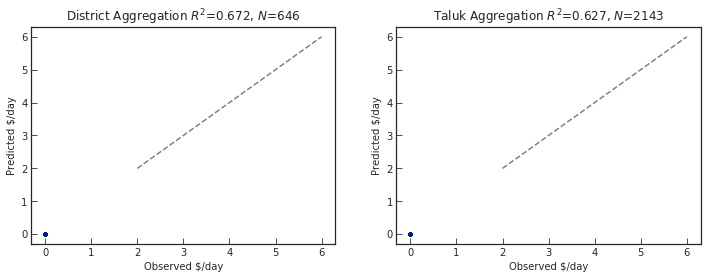

In [612]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(np.exp(trues["district"]) / 365.25 / 16.013, 
            np.exp(preds["district"]) / 365.25 / 16.013,
            marker=".", alpha=0.1)
plt.plot((2,6), (2,6), "--", color="grey")
plt.xlabel("Observed $/day")
plt.ylabel("Predicted $/day")
r2 = r2_score(trues["district"], preds["district"])
plt.title("District Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(trues["district"])))
plt.subplot(1,2,2)
plt.scatter(np.exp(trues["taluk"]) / 365.25 / 16.013, 
            np.exp(preds["taluk"]) / 365.25 / 16.013,
            marker=".", alpha=0.05)
plt.plot((2,6), (2,6), "--", color="grey")
plt.xlabel("Observed $/day")
plt.ylabel("Predicted $/day")
r2 = r2_score(trues["taluk"], preds["taluk"])
plt.title("Taluk Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(trues["taluk"])));

In [575]:
marshall_district = pd.DataFrame({
  "preds_district": preds["district"],
  "trues_district": trues["district"]
})

In [35]:
marshall_taluk = pd.DataFrame({
  "preds_taluk": preds["taluk"],
  "trues_taluk": trues["taluk"]
})

In [34]:
# marshall_district.to_csv("./marshall_district.csv")
# marshall_taluk.to_csv("./marshall_taluk.csv")

In [585]:
state_shapes = shapefile.Reader("../data/india_shape_files/IND_adm1.shp").shapes()
state_polygons = [sgeom.shape(s.__geo_interface__) for s in state_shapes]

In [586]:
district_shapes = shapefile.Reader("../data/india_shape_files/IND_adm2").shapes()
district_polygons = [sgeom.shape(s.__geo_interface__) for s in district_shapes]

In [587]:
taluk_shapes = shapefile.Reader("../data/india_shape_files/IND_adm3").shapes()
taluk_polygons = [sgeom.shape(s.__geo_interface__) for s in taluk_shapes]

In [588]:
taluk_areas = [p.area for p in taluk_polygons]

In [331]:
np.percentile(taluk_areas, [2.5, 50, 97.5])

array([0.00390405, 0.09215641, 0.38633432])

In [589]:
polygons = {
  "state": state_polygons,
  "district": district_polygons, 
  "taluk": taluk_polygons
}

In [596]:
bins = jenks_breaks(np.r_[np.exp(trues["taluk"].values) / 365.25 / 16.013, 
                          np.exp(preds["taluk"].values) / 365.25 / 16.013], nb_class=4)

In [597]:
heatmap_colors = sns.color_palette("hot", 5)[::-1]

In [598]:
def plot_true_vs_pred(division_level):

  fig = plt.figure(figsize=(14, 8))

  countries = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(np.exp(preds[division_level]) / 365.25 / 16.013 - 1e-4, bins)
  for i, color in zip(preds[division_level].keys(), colors):
    polygon = polygons[division_level][i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Predicted", fontweight="bold", fontsize=12)

  ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(np.exp(trues[division_level]) / 365.25 / 16.013 - 1e-4, bins)
  for i, color in zip(trues[division_level].keys(), colors):
    polygon = polygons[division_level][i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Actual", fontweight="bold", fontsize=12)

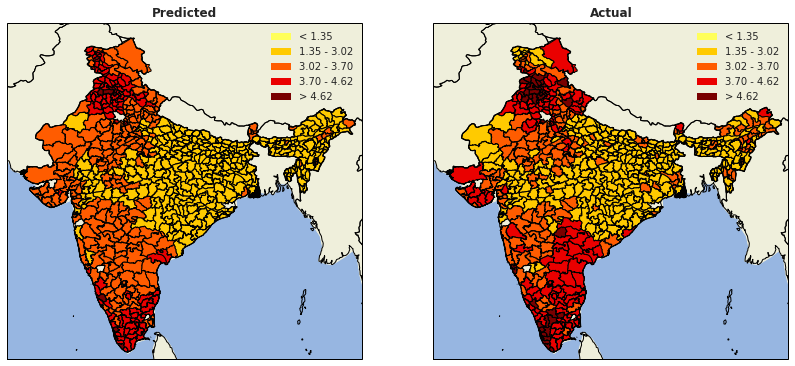

In [600]:
plot_true_vs_pred("district")

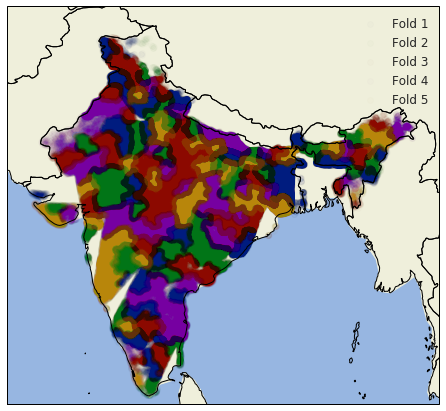

In [252]:
plt.figure(figsize=(6, 8))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([67, 99, 7.5, 36])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')
for i in range(1, 5 + 1):
  plt.scatter(test_df["lng"][test_df["fold"] == i], 
              test_df["lat"][test_df["fold"] == i], 
              label="Fold %d" % i, alpha=0.01)
ax.add_feature(states_provinces, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0)
plt.legend()

In [57]:
def plot_diffs(division_level):
  
  plt.figure(figsize=(6, 8))
  
  ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
  ax.set_extent([67, 99, 7.5, 36])

  states_provinces = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  cmap = plt.cm.hot
  values = np.abs(preds[division_level] - trues[division_level])
  vmin = np.min(values)
  vmax = np.max(values)

  for i, polygon in enumerate(polygons[division_level]):
    if i in values:
      color = rgb2hex(cmap(1-np.sqrt((values[i]-vmin)/(vmax-vmin))))
      poly = PolygonPatch(polygon, facecolor=color, edgecolor="black")
      ax.add_patch(poly)

  ax.add_feature(states_provinces, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)

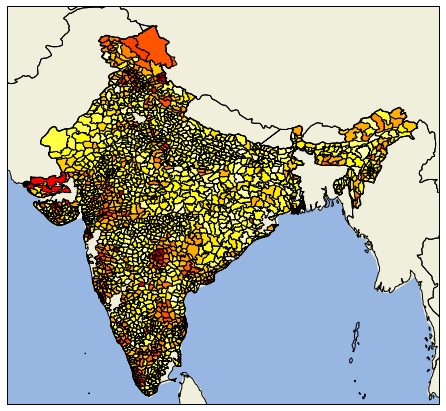

In [59]:
plot_diffs("taluk")

In [61]:
india_processed = pd.read_csv("../data/india_processed.csv")

In [180]:
india_processed["secc_cons_per_cap_scaled"].sample(15)

389680    18713.917969
129069    15271.842773
299376    10235.687500
93366     13724.507812
175710    16299.648438
379738    18621.908203
138178    16162.834961
303205     9832.170898
380417    15534.228516
139589    15579.203125
294782    14939.813477
425462    23256.867188
343815    14303.256836
236288     9863.154297
359032    18373.775391
Name: secc_cons_per_cap_scaled, dtype: float64

In [198]:
row = india_processed.iloc[9888,]

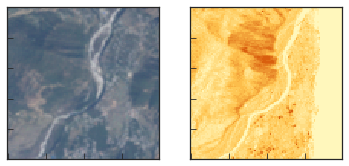

In [199]:
plt.figure(figsize=(6, 3))
ax = plt.subplot(1,2,1)
img = Image.open("../../imagery/" + row["l8_path"])
plt.imshow(img.crop((200, 200, 300, 300)).resize((100, 100)))
ax.set_xticklabels(())
ax.set_yticklabels(())
ax = plt.subplot(1,2,2)
img = Image.open("../../imagery/" + row["s1_path"])
plt.imshow(img.crop((100, 100, 400, 400)).resize((100, 100)))
ax.set_xticklabels(())
ax.set_yticklabels(());

In [83]:
bangladesh_df = pd.read_csv("../data/bangladesh_test.csv")

In [92]:
bangladesh_df["l8"] = np.load("./bangladesh/y_pred_l8.npy")
bangladesh_df["s1"] = np.load("./bangladesh/y_pred_s1.npy")
bangladesh_df["pred"] = np.mean((bangladesh_df["s1"], bangladesh_df["l8"]), axis=0)

In [102]:
def calculate_concordance(trues, preds):
  concordance, N = 0, len(trues)
  counter = 0
  for i in range(N):
    for j in range(i + 1, N):
      if (preds[i] < preds[j] and trues[i] < trues[j]) or \
         (preds[i] > preds[j] and trues[i] > trues[j]):
          concordance += 1
      elif preds[i] == preds[j]:
        concordance += 0.5
      counter += 1
  return concordance / counter

In [103]:
calculate_concordance(bangladesh_df["totexp_m_pc"], bangladesh_df["pred"])

0.5014020707506471

In [104]:
train = pd.read_csv("../data/fold_1/train.csv")
valid = pd.read_csv("../data/fold_1/valid.csv")
test = pd.read_csv("../data/fold_1/test.csv")

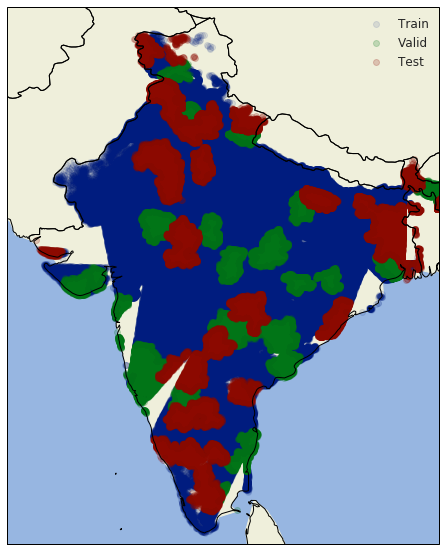

In [111]:
plt.figure(figsize=(6, 8))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([67, 90, 7.5, 36])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')
plt.scatter(train["longitude"],
            train["latitude"],
            label="Train", alpha=0.1)
plt.scatter(valid["longitude"],
            valid["latitude"],
            label="Valid", alpha=0.2)
plt.scatter(test["longitude"],
            test["latitude"],
            label="Test", alpha=0.2)
ax.add_feature(states_provinces, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0)
plt.legend()